In [97]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [98]:
from modules.plots._shared import Figsize, _save_or_show, Color

In [99]:
import modules.experiment.events as expevents
import modules.experiment.fov as expfov
import modules.utils as utils
import modules.plots.experimental_data as expplots
import modules.eas_reconstruction as eas

from modules_reloader import reloader

relmod = reloader(expevents, expfov, utils, expplots, eas)

In [100]:
relmod()

In [101]:
processor = expevents.EventProcessor(N=45, verbosity=1, load_rir=False, min_signal_significance=4)
L = 10
N = processor.N

In [102]:
event_id = 10685
event = expevents.Event(event_id)

In [103]:
fov = expfov.PmtFov.for_event(event_id)

In [104]:
n_samples, has_signal = processor.read_reconstruction_marginal_sample_per_channel(event.id_, parameter='n')
significant = processor.read_signal_significances(event.id_)[has_signal] > processor.min_signal_significance
axis_theta, axis_phi, inplane = processor.reconstruct_eas_angle(event)

channels = np.arange(109)

channels = channels[has_signal][significant][inplane]
n_samples = n_samples[:, significant][:, inplane]

In [105]:
n_samples = np.round(n_samples).astype(int)

In [106]:
n_means_raw = n_samples.mean(axis=0)
n_stds_raw = n_samples.std(axis=0)

In [107]:
n_means = np.zeros((n_samples.shape[1]))
n_stds = np.zeros((n_samples.shape[1]))

for i, n_i_sample in enumerate(n_samples.T):
    n_i_sample_round = np.round(n_i_sample).astype(int)
    p_obs = np.bincount(n_i_sample_round[n_i_sample_round > 0])
    n_obs = np.arange(p_obs.size)
    n_obs = n_obs[p_obs > 0]
    p_obs = p_obs[p_obs > 0]

    # lmb_min = max(n_obs.min() / 2, 0)
    lmb_query = np.linspace(0.0, 2 * n_obs.max(), 1000, dtype=float)
    p_obs = p_obs / np.sum(p_obs)

    lmb_pdf = np.zeros_like(lmb_query)
    for n, p in zip(n_obs, p_obs):
        lmb_pdf += p*scipy.stats.poisson.pmf(n, lmb_query)

    lmb_step = lmb_query[1] - lmb_query[0]
    n_final_mean = np.sum(lmb_query * lmb_pdf * lmb_step)
    n_sq_final_mean = np.sum(lmb_query**2 * lmb_pdf * lmb_step)
    n_final_std = np.sqrt(n_sq_final_mean - n_final_mean ** 2)

    n_means[i] = n_final_mean
    n_stds[i] = n_final_std

    # plt.hist(n_i_sample, density=True)
    # plt.plot(lmb_query, lmb_pdf)
    # break

    # print(f'before poisson: {n_i_sample.mean()} +/- {n_i_sample.std()}')
    # print(f'after poisson: {n_final_mean} +/- {n_final_std}')


# Величины уширения распределения $\lambda$ по сравнению с $n$

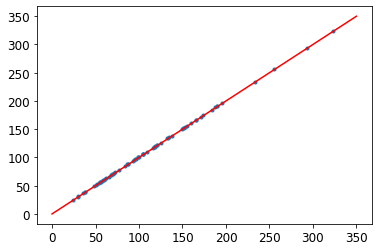

In [108]:
plt.plot(n_means_raw, n_means, '.')
plt.plot([0, 350], [0, 350], 'r-')

In [109]:
print(np.median(n_means / n_means_raw))

1.0101653812694038


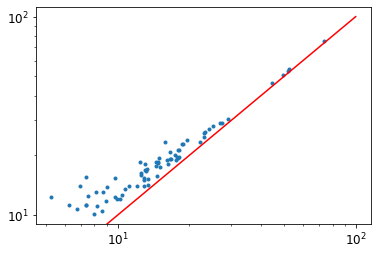

In [110]:
plt.plot(n_stds_raw, n_stds, '.')
plt.plot([0, 100], [0, 100], 'r-')

plt.yscale('log')
plt.xscale('log')

In [111]:
axis_x, axis_y, _, _ = processor.read_eas_geometry(event.id_)

In [112]:
axis_x_proj, axis_y_proj = eas.project_on_shower_plane(np.array([axis_x]), np.array([axis_y]), axis_theta, axis_phi)

In [113]:
fov_x_proj, fov_y_proj = eas.project_on_shower_plane(fov.x, fov.y, axis_theta, axis_phi)

fov_x_proj -= axis_x_proj
fov_y_proj -= axis_y_proj

In [114]:
from scipy.interpolate import griddata
from tqdm import trange

FOV_proj = np.zeros((109, fov.side, fov.side))

for i_ch in trange(109):
    fov_grid = fov.grid()
    x_ch, y_ch = np.meshgrid(fov_grid, fov_grid)
    x_ch = x_ch.flatten()
    y_ch = y_ch.flatten()
    x_ch_proj, y_ch_proj = eas.project_on_shower_plane(x_ch, y_ch, axis_theta, axis_phi)
    FOV_ch = np.squeeze(fov.FOV[i_ch, :, :]).flatten()
    FOV_proj[i_ch, :, :] = griddata(
        utils.concat_vectors_as_cols(x_ch_proj, y_ch_proj),
        FOV_ch,
        utils.concat_vectors_as_cols(x_ch, y_ch),
        method='cubic',
        fill_value=0.0,
    ).reshape(fov.side, fov.side)


fov_proj = expfov.PmtFov(
    FOVc=np.concatenate((np.expand_dims(fov_x_proj, 1), np.expand_dims(fov_y_proj, 1)), axis=1),
    FOV=FOV_proj
)

100%|██████████| 109/109 [00:04<00:00, 24.84it/s]


In [115]:
# see https://arxiv.org/pdf/astro-ph/0511215.pdf

def Q(x, y, P, Qkn):
    R = np.sqrt(x ** 2 + y ** 2)
    R0 = 10 ** (2.95 - 0.245 * P)
    Rkn = 155 - 13 * P
    b = 1.19 + 0.23 * P
    Q_ = np.zeros_like(R)
    priaxis = R < Rkn
    Q_[priaxis] = Qkn * np.exp((Rkn - R[priaxis]) * (1 + 3 / (R[priaxis] + 3)) / R0)
    wings = R >= Rkn
    Q_[wings] = Qkn * (Rkn / R[wings]) ** b
    return Q_

def theory_n_phels_in_ch(channels, P, Qkn):
    res = np.ones_like(channels, dtype=float)
    for idx, i_ch in enumerate(channels):
        i_ch = int(i_ch)
        # see 13_pmt_quantum_efficiencies.ipynb for magic numbers
        #           Hamamatsu                                ФЭУ84-3
        coeff = 1 / 2.943031538444593 if i_ch == 0 else 1 / 2.5745613410569366
        fov_grid = fov_proj.grid()
        x, y = np.meshgrid(fov_grid, fov_grid)
        x = x.flatten() + fov_proj.FOVc[i_ch, 0]
        y = y.flatten() + fov_proj.FOVc[i_ch, 1]
        f = np.squeeze(fov_proj.FOV[i_ch, :, :]).flatten()
        x = x[f > 1e-15]
        y = y[f > 1e-15]
        f = f[f > 1e-15]
        Q_vals = Q(x, y, P, Qkn)
        res[idx] = coeff * np.sum(Q_vals * f) * fov_proj.step ** 2
    return res


In [116]:
init_P = 3.0
init_Qkn = n_means[0] / theory_n_phels_in_ch(np.array([0]), init_P, 1)[0]

In [117]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(
    theory_n_phels_in_ch,
    channels,
    n_means,
    p0=np.array([init_P, init_Qkn]),
    sigma=n_stds,
    absolute_sigma=True,
)

In [118]:
P, Qkn = popt
Perr, Qknerr = np.sqrt(np.diag(pcov))

print(f"Qkn = {Qkn} +/- {Qknerr}")
print(f"P = {P} +/- {Perr}")

Qkn = 2236.7151464623216 +/- 48.03167819767281
P = 4.054825493676533 +/- 0.08826158398738208


# Упрощённый график-иллюстрация для фитирования

In [119]:
def lambda_by_Qexp(i_ch):
    # see 13_pmt_quantum_efficiencies.ipynb for magic numbers
    #           Hamamatsu                                ФЭУ84-3
    coeff = 1 / 2.943031538444593 if i_ch == 0 else 1 / 2.5745613410569366
    f = np.squeeze(fov_proj.FOV[i_ch, :, :]).flatten()
    return coeff * np.sum(f) * fov_proj.step ** 2

In [120]:
lambda_by_Qexps = np.array([lambda_by_Qexp(i_ch) for i_ch in channels])

Q_exp = n_means / lambda_by_Qexps
Q_exp_std = n_stds / lambda_by_Qexps

In [121]:
R_exp = np.sqrt(fov_proj.FOVc[channels, 0] ** 2 + fov_proj.FOVc[channels, 1] ** 2)

In [122]:
from itertools import product
from tqdm import tqdm

def E0(Q175):
    return 400 * Q175 ** 0.95

samplesize = 500

Q_kn_sample = np.random.normal(loc=Qkn, scale=Qknerr, size=samplesize)
P_sample = np.random.normal(loc=P, scale=Perr, size=samplesize)

E0_sample = np.zeros((samplesize ** 2,))

for i, (Q_r, P_r) in tqdm(enumerate(product(Q_kn_sample, P_sample)), total=samplesize ** 2):
    Q175 = Q(np.array([175.0]), np.array([0.0]), Qkn=Q_r, P=P_r)[0]
    E0_sample[i] = E0(Q175)

100%|██████████| 250000/250000 [00:07<00:00, 31254.55it/s]


In [123]:
E0_sample = E0_sample / 10**3  # TeV -> PeV

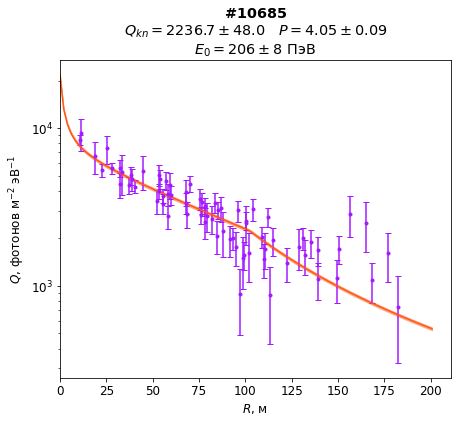

In [124]:
fig, ax = plt.subplots(figsize=(7, 5.85))

ax.errorbar(R_exp, Q_exp, yerr=Q_exp_std, capsize=3, fmt='.', color=Color.THETA.value)

approx_color='#FF5714'

R_th = np.linspace(0, R_exp.max() * 1.1, 100)
Q_th = Q(R_th, np.zeros_like(R_th), Qkn=Qkn, P=P)
ax.plot(R_th, Q_th, color=approx_color)

ax.fill_between(
    R_th,
    Q(R_th, np.zeros_like(R_th), Qkn=Qkn-Qknerr, P=P),
    Q(R_th, np.zeros_like(R_th), Qkn=Qkn+Qknerr, P=P),
    color=approx_color,
    alpha=0.4
)

ax.set_yscale('log')
ax.set_xlim(left=0)
ax.set_xlabel('$R$, м')
ax.set_ylabel('$Q$, фотонов м$^{-2}$ эВ$^{-1}$')

ldf_params_str = f"$Q_{{kn}} = {Qkn:.1f} \\pm {Qknerr:.1f} \\quad P = {P:.2f} \\pm {Perr:.2f}$"
E0_str = f"$E_0 = {E0_sample.mean():.0f} \pm {E0_sample.std():.0f}$ ПэВ"
ax.set_title(f'$\\bf{{\\#{event.id_}}}$\n{ldf_params_str}\n{E0_str}')

_save_or_show(f'ldf-fit-{event.id_}')

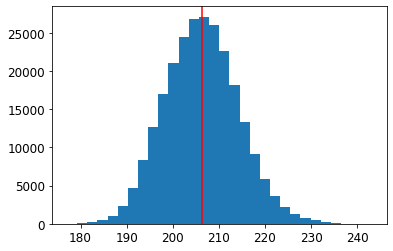

In [125]:
plt.hist(E0_sample, bins=30)
plt.axvline(E0_sample.mean(), color='r')